In [4]:
import pymc as pm
import arviz as az

In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Ignore a common pymc3 warning that comes from library functions, not our code.
# Pymc3 may throw additional warnings, but other warnings should be manageable
# by following the instructions included within the warning messages.
import warnings

messages=[
    "Using `from_pymc3` without the model will be deprecated in a future release",
]

for m in messages:
    warnings.filterwarnings("ignore", message=m)

In [7]:
n_theta = 10000

# generate 10,000 values from Beta(2,5)
theta = np.random.beta(2,5,n_theta)
print("First five  values of theta:\n\t", theta[0:5])
print("Sample mean:\n\t", np.mean(theta))
print("The 2.5% and 97.5% of quantiles:\n\t", np.percentile(theta,[2.5,97.5]))

First five  values of theta:
	 [0.0293929  0.10787185 0.15554865 0.11947265 0.27886729]
Sample mean:
	 0.28572015570431913
The 2.5% and 97.5% of quantiles:
	 [0.04143307 0.64031948]


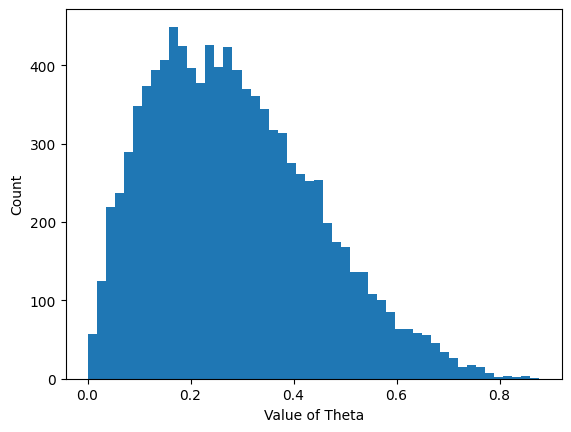

In [8]:
plt.hist(theta,50)
plt.xlabel("Value of Theta")
plt.ylabel("Count")
plt.show()

First 5 heads/tails values (tails=0, heads=1)
	 [0 0 0 0 0 1 1 1 0 0]
Overall frequency of Tails and Heads, accounting for uncertainty about theta itself
	 [0.716 0.284]


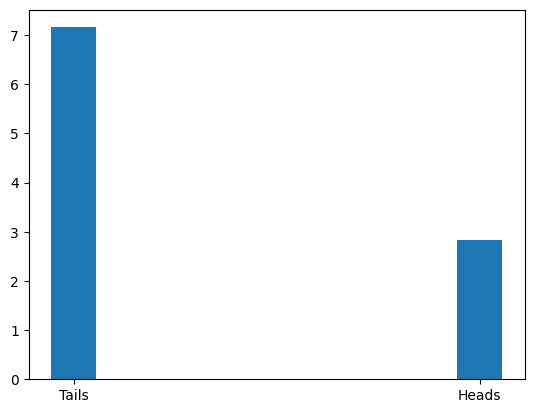

In [9]:
# simulate y from posterior predictive distribution
y = np.random.binomial(1, theta, n_theta) # generate a heads/tails value from each of the 10,000 thetas

print("First 5 heads/tails values (tails=0, heads=1)\n\t", y[0:10])
print("Overall frequency of Tails and Heads, accounting for uncertainty about theta itself\n\t", np.bincount(y)/10000)

plt.hist(y, density=True)
plt.xticks([.05,.95],["Tails","Heads"])
plt.show()

## Rejection sampling and Weighted bootstrap

Example adapted from https://wiseodd.github.io/techblog/2015/10/21/rejection-sampling/

In [10]:
sns.set()

def h(x):
    return st.norm.pdf(x, loc=30, scale=10) + st.norm.pdf(x, loc=80, scale=20)


def g(x):
    return st.norm.pdf(x, loc=50, scale=30)


x = np.arange(-50, 151)
M = max(h(x) / g(x))  # for rejection sampling

h is a mixture of two normal distributions (unnormalized), and density h is a normal distribution with mean 50 and standard deviation 30.

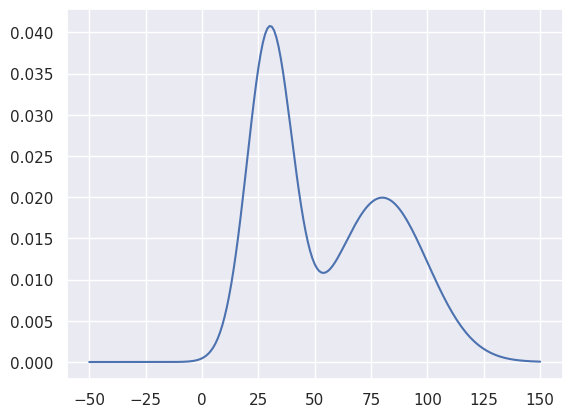

In [11]:
plt.plot(x, h(x))
plt.show()

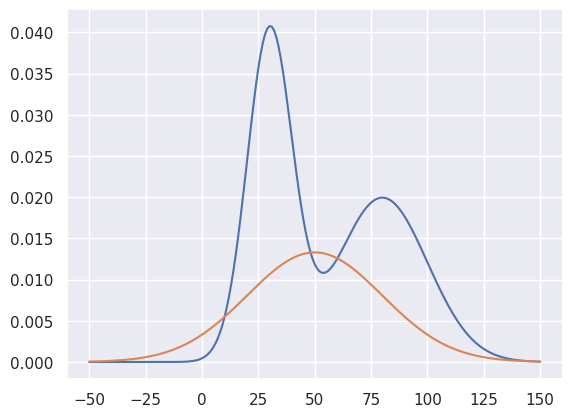

In [14]:
# Superimpose h and g on same plot
plt.plot(x,h(x))
plt.plot(x,g(x))
plt.show()

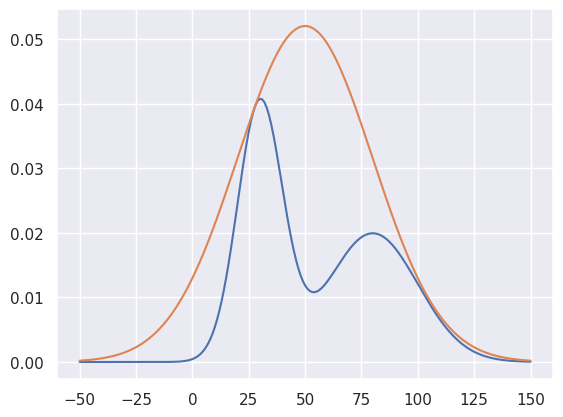

In [15]:
# Superimpose h and M*g on same plot - now M*g envelopes h
plt.plot(x,h(x))
plt.plot(x,M*g(x))
plt.show()

Rejection rate is 50.07488766849726


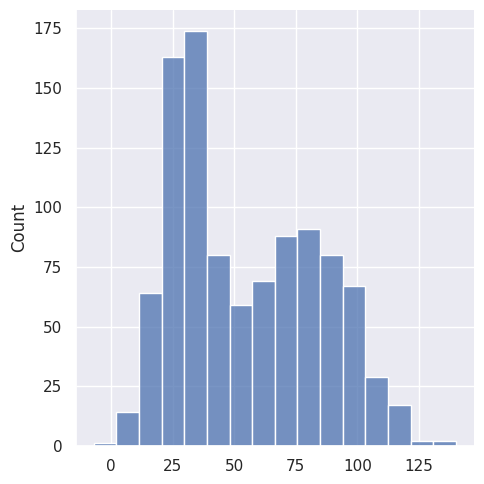

In [16]:
def rejection_sampling(maxiter=10000,sampsize=1000):
    samples = []
    sampcount = 0  # counter for accepted samples
    maxcount = 0   # counter for proposal simulation
    # sampcount/maxcount at any point in the iteration is the acceptance rate

    while (sampcount < sampsize and maxcount < maxiter):
        z = np.random.normal(50, 30)
        u = np.random.uniform(0, 1)
        maxcount += 1

        if u <= h(z)/(M*g(z)):
            samples.append(z)
            sampcount += 1

    print('Rejection rate is',100*(1-sampcount/maxcount))
    if maxcount == maxiter: print('Maximum iterations achieved')
    return np.array(samples)

s = rejection_sampling(maxiter=10000,sampsize=1000)
sns.displot(s)

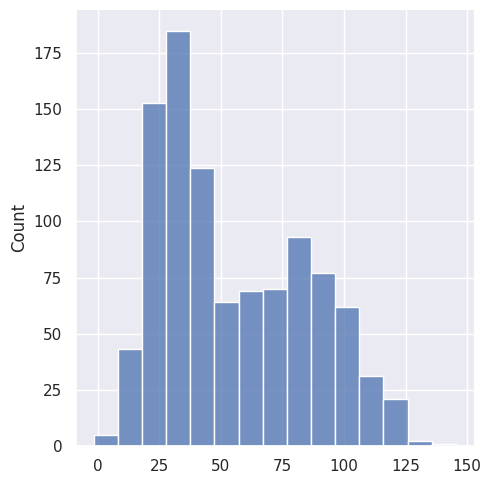

In [17]:
# weighted bootstrap computation involving h and g
import random

def weighted_bootstrap(iter=1000,size=100):
    w = []
    y = []

    for i in range(iter):
        z = np.random.normal(50, 30)
        y.append(z)
        wz = h(z)/g(z)
        w.append(wz)

    v = random.choices(y,weights=w,k=size) # do not need to renormalize w
    return np.array(v)

wb = weighted_bootstrap(iter=10000,size=1000)
sns.displot(wb)

## Beetles

In [18]:
beetles_x = np.array([1.6907, 1.7242, 1.7552, 1.7842, 1.8113, 1.8369, 1.8610, 1.8839])
beetles_x_mean = beetles_x - np.mean(beetles_x)
beetles_n = np.array([59, 60, 62, 56, 63, 59, 62, 60])
beetles_y = np.array([6, 13, 18, 28, 52, 53, 61, 60])
beetles_N = np.array([8]*8)

In [19]:
from scipy.special import expit
expit(2)

np.float64(0.8807970779778823)

In [20]:
with pm.Model() as beetle_model:
    # The intercept (log probability of beetles dying when dose=0)
    # is centered at zero, and wide-ranging (easily anywhere from 0 to 100%)
    # If we wanted, we could choose something like Normal(-3,2) for a no-dose
    # death rate roughly between .007 and .25
    alpha_star = pm.Normal('alpha*', mu=0, sigma=100)
    # the effect on the log-odds of each unit of the dose is wide-ranging:
    # we're saying we've got little idea what the effect will be, and it could
    # be strongly negative.
    beta = pm.Normal('beta', mu=0, sigma=100)

    # given alpha, beta, and the dosage, the probability of death is deterministic:
    # it's the inverse logit of the intercept+slope*dosage
    # Because beetles_x has 8 entries, we end up with 8 p_i values
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(alpha_star + beta*beetles_x_mean))

    # finally, the number of bettles we see killed is Binomial(n=number of beetles, p=probability of death)
    deaths = pm.Binomial('obs_deaths', n=beetles_n, p=p_i, observed=beetles_y)

    trace = pm.sample(2000, tune=2000, target_accept=0.9)

Output()

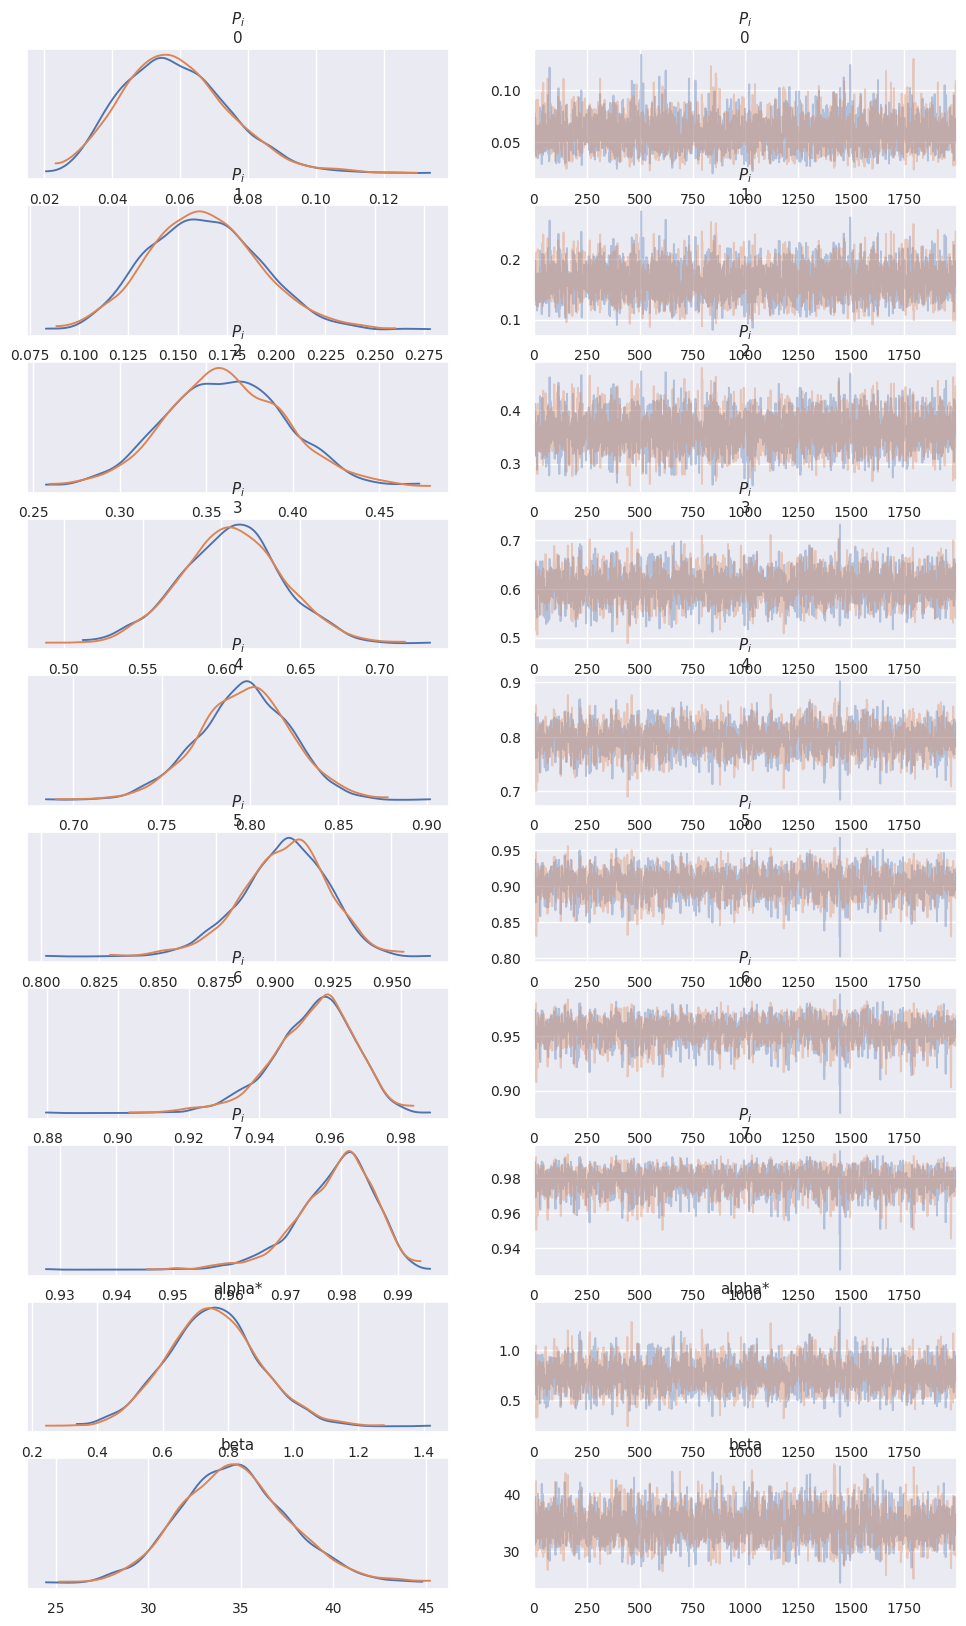

In [21]:
az.plot_trace(trace, compact=False);

In [24]:
def trace_summary(trace, var_names=None):
    if var_names is None:
        var_names = list(trace.posterior.data_vars)

    quants = [0.025,0.25,0.5,0.75,0.975]
    colnames = ['mean', 'sd', *["{}%".format(x*100) for x in quants]]
    rownames = []

    series = []
    for cur_var in var_names:
        var_trace = trace.posterior[cur_var]
        if var_trace.ndim == 1:
            vals = [np.mean(var_trace, axis=0), np.std(var_trace, axis=0), *np.quantile(var_trace, quants, axis=0)]
            series.append(pd.Series(vals, colnames))
            rownames.append(cur_var)
        else:
            for i in range(var_trace.shape[1]):
                cur_col = var_trace[:,i]
                vals = [np.mean(cur_col, axis=0), np.std(cur_col, axis=0), *np.quantile(cur_col, quants, axis=0)]
                series.append(pd.Series(vals, colnames))
                rownames.append("{}[{}]".format(cur_var,i))

    return pd.DataFrame(series, index=rownames)

trace_summary(trace)

,mean,sd,2.5%,25.0%,50.0%,75.0%,97.5%
$P_i$[0],[<xarray.DataArray '$P_i$' ()> Size: 8B\narray...,[<xarray.DataArray '$P_i$' ()> Size: 8B\narray...,"[0.037754942749356875, 0.12992532861378514, 0....","[0.03848333365533633, 0.1309693965377999, 0.33...","[0.03929265688420239, 0.13212947200892738, 0.3...","[0.04010198011306845, 0.1332895474800549, 0.33...","[0.040830371019047906, 0.13433361540406966, 0...."
$P_i$[1],[<xarray.DataArray '$P_i$' ()> Size: 8B\narray...,[<xarray.DataArray '$P_i$' ()> Size: 8B\narray...,"[0.04742974249031217, 0.14826906307220095, 0.3...","[0.05297074229780194, 0.15734935886067578, 0.3...","[0.059127408750568336, 0.16743857640342558, 0....","[0.06528407520333475, 0.17752779394617538, 0.3...","[0.07082507501082451, 0.1866080897346502, 0.38..."
$P_i$[2],[<xarray.DataArray '$P_i$' ()> Size: 8B\narray...,[<xarray.DataArray '$P_i$' ()> Size: 8B\narray...,"[0.07014948876067126, 0.18243681800154796, 0.3...","[0.07196113560747014, 0.18482737227217766, 0.3...","[0.07397407654835778, 0.18748354368398845, 0.3...","[0.07598701748924541, 0.19013971509579922, 0.3...","[0.0777986643360443, 0.19253026936642892, 0.38..."
$P_i$[3],[<xarray.DataArray '$P_i$' ()> Size: 8B\narray...,[<xarray.DataArray '$P_i$' ()> Size: 8B\narray...,"[0.043707217728149596, 0.14659304027441647, 0....","[0.04476777089162932, 0.14747659372922017, 0.3...","[0.04594616329549567, 0.14845831979011315, 0.3...","[0.047124555699362025, 0.14944004585100612, 0....","[0.04818510886284175, 0.15032359930580982, 0.3..."
$P_i$[4],[<xarray.DataArray '$P_i$' ()> Size: 8B\narray...,[<xarray.DataArray '$P_i$' ()> Size: 8B\narray...,"[0.05486268394678721, 0.15883708355543397, 0.3...","[0.057827751381856904, 0.16582053152612286, 0....","[0.06112227075415656, 0.1735799181602216, 0.38...","[0.06441679012645624, 0.18133930479432037, 0.3...","[0.06738185756152593, 0.18832275276500926, 0.4..."
...,...,...,...,...,...,...,...
beta[1995],<xarray.DataArray 'beta' ()> Size: 8B\narray(3...,<xarray.DataArray 'beta' ()> Size: 8B\narray(3...,29.430399,31.048871,32.847174,34.645476,36.263948
beta[1996],<xarray.DataArray 'beta' ()> Size: 8B\narray(3...,<xarray.DataArray 'beta' ()> Size: 8B\narray(2...,34.436552,35.603833,36.900812,38.197791,39.365073
beta[1997],<xarray.DataArray 'beta' ()> Size: 8B\narray(3...,<xarray.DataArray 'beta' ()> Size: 8B\narray(0...,32.982089,33.358439,33.776605,34.194772,34.571121
beta[1998],<xarray.DataArray 'beta' ()> Size: 8B\narray(3...,<xarray.DataArray 'beta' ()> Size: 8B\narray(2...,33.232947,34.444621,35.790926,37.13723,38.348904


We can also plot the density each chain explored. Any major deviations between chains are signs of difficulty converging.

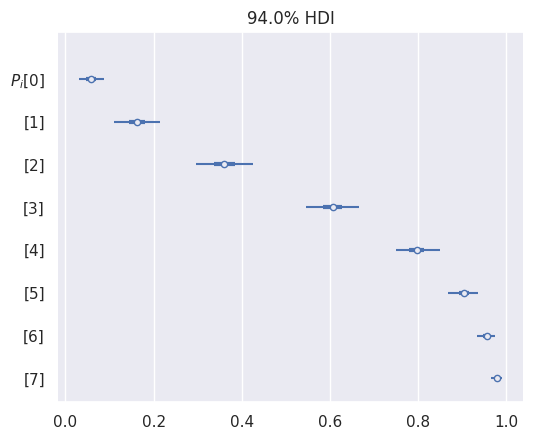

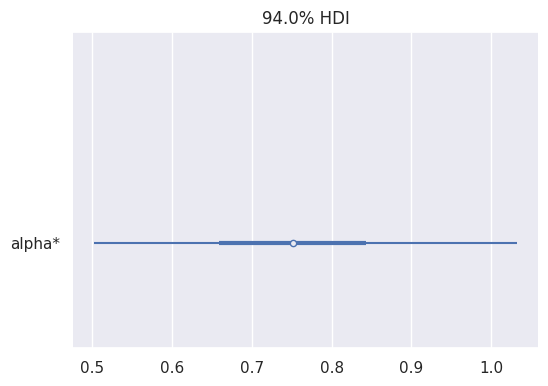

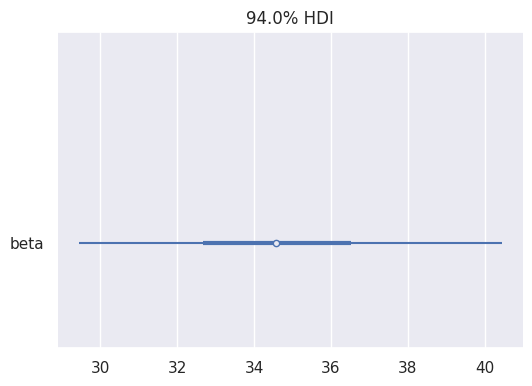

In [26]:
for x in list(trace.posterior.data_vars):
    az.plot_forest(trace, var_names=[x], combined=True)

In addition to the above summaries of the distribution, pymc3 has statistics intended to summarize the quality of the samples. The most common of these is r_hat, which measures whether the different chains seem to be exploring the same space or if they're stuck in different spaces. R-hat above 1.3 is a strong sign the sample isn't good yet. Values close to 1 are ideal.

In [27]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$P_i$[0],0.059,0.016,0.031,0.088,0.000,0.000,3212.0,2654.0,1.0
$P_i$[1],0.164,0.028,0.111,0.214,0.000,0.000,3831.0,2831.0,1.0
$P_i$[2],0.362,0.034,0.297,0.425,0.001,0.001,4148.0,3158.0,1.0
$P_i$[3],0.606,0.032,0.545,0.667,0.001,0.000,2954.0,2500.0,1.0
$P_i$[4],0.797,0.026,0.750,0.850,0.001,0.000,1744.0,2021.0,1.0
$P_i$[5],0.904,0.019,0.868,0.936,0.000,0.000,1648.0,2075.0,1.0
$P_i$[6],0.955,0.012,0.933,0.976,0.000,0.000,1655.0,2242.0,1.0
$P_i$[7],0.979,0.007,0.966,0.991,0.000,0.000,1686.0,2233.0,1.0
alpha*,0.754,0.140,0.503,1.032,0.003,0.002,2192.0,2325.0,1.0
beta,34.672,2.927,29.443,40.447,0.065,0.049,2033.0,2467.0,1.0


## Sleep Study

In [31]:
import pandas as pd
url = "https://raw.githubusercontent.com/kennethmleo/CS109B/main/Lecture%2007/data/sleepstudy.csv"
sleepstudy = pd.read_csv(url)

In [32]:
sleepstudy

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
...,...,...,...
175,329.6076,5,372
176,334.4818,6,372
177,343.2199,7,372
178,369.1417,8,372


In [33]:
# adding a column that numbers the subjects from 0 to n
raw_ids = np.unique(sleepstudy['Subject'])
raw2newid = {x:np.where(raw_ids == x)[0][0] for x in raw_ids}

sleepstudy['SeqSubject'] = sleepstudy['Subject'].map(raw2newid)
sleepstudy

,Reaction,Days,Subject,SeqSubject
0,249.5600,0,308,0
1,258.7047,1,308,0
2,250.8006,2,308,0
3,321.4398,3,308,0
4,356.8519,4,308,0
...,...,...,...,...
175,329.6076,5,372,17
176,334.4818,6,372,17
177,343.2199,7,372,17
178,369.1417,8,372,17


In [34]:
with pm.Model() as sleep_model:

    # In this model, we're going to say the alphas (individuals' intercepts; their starting reaction time)
    # and betas (individuals' slopes; how much worse they get with lack of sleep) are normally distributed.
    # We'll specify that we're certain about the mean of those distribution [more on that later], but admit
    # we're uncertain about how much spread there is (i.e. uncertain about the SD). Tau_alpha and Tau_beta
    # will be the respective SD.
    #
    # Of course, the SDs must be positive (negative SD isn't mathematically possible), so we draw them from
    # a Gamma, which cannot ever output negative numbers. Here, we use alpha and beta values that spread the
    # distribution: "the SD could be anything!". If we had more intuition (e.g. "the starting reaction times can't
    # have SD above 3,000") we would plot Gamma(a,b) and tune the parameters so that there was little mass
    # above 3,000, then use those values below)
    tau_alpha = pm.Gamma('tau_alpha', alpha=.001, beta=.001)
    tau_beta = pm.Gamma('tau_beta', alpha=.001, beta=.001)

    # Across the population of people, we suppose that
    # the slopes are normally distributed, as are the intercepts,
    # and the two are drawn independently
    #
    # (Here, we hard-code assumed means, but we don't have to.
    # In general, these should be set from our pre-data intuition,
    # rather than from plots/exploration of the data)
    alpha = pm.Normal('alpha', mu=300, tau=tau_alpha, shape=len(raw_ids))
    beta = pm.Normal('beta', mu=10, tau=tau_beta, shape=len(raw_ids))

    # Remember: there's only one alpha/beta per person, but
    # we have lots of observations per person. The below
    # builds a vector with one entry per observation, recording
    # the alpha/beta we want to use with that observation.
    #
    # That is, the length is 180, but it only has 17 unique values,
    # matching the 17 unique patients' personal slopes or intercepts
    intercepts = alpha[sleepstudy['SeqSubject']]
    slopes = beta[sleepstudy['SeqSubject']]

    # now we have the true/predicted response time for each observation (each row of original data)
    # (Here we use pm.Deterministic to signal that this is something we'll care about)
    mu_i = pm.Deterministic('mu_i', intercepts + slopes*sleepstudy['Days'])

    # The _observed_ values are noisy versions of the hidden true values, however!
    # Specifically, we model them as a normal at the true value and single unknown variance
    # (one explanation: we're saying the measurement equipment adds normally-distributed noise tau_obs
    # so noise doesn't vary from observation to observation or person to person: there's just one universal
    # noise level)
    tau_obs = pm.Gamma('tau_obs', 0.001, 0.001)
    obs = pm.Normal('observed', mu=mu_i, tau=tau_obs, observed=sleepstudy['Reaction'])

    trace = pm.sample(2000, tune=2000, target_accept=0.9)

Output()

In [ ]:
# this command can take a few minutes to finish... or never :-/
#az.plot_trace(trace);

In [35]:
trace_summary(trace, var_names=['tau_alpha', 'tau_beta', 'alpha', 'beta', 'tau_obs'])

,mean,sd,2.5%,25.0%,50.0%,75.0%,97.5%
tau_alpha[0],<xarray.DataArray 'tau_alpha' ()> Size: 8B\nar...,<xarray.DataArray 'tau_alpha' ()> Size: 8B\nar...,0.000206,0.00021,0.000215,0.00022,0.000225
tau_alpha[1],<xarray.DataArray 'tau_alpha' ()> Size: 8B\nar...,<xarray.DataArray 'tau_alpha' ()> Size: 8B\nar...,0.000151,0.000165,0.000181,0.000197,0.000211
tau_alpha[2],<xarray.DataArray 'tau_alpha' ()> Size: 8B\nar...,<xarray.DataArray 'tau_alpha' ()> Size: 8B\nar...,0.000228,0.000263,0.000301,0.000339,0.000373
tau_alpha[3],<xarray.DataArray 'tau_alpha' ()> Size: 8B\nar...,<xarray.DataArray 'tau_alpha' ()> Size: 8B\nar...,0.00022,0.000232,0.000246,0.00026,0.000272
tau_alpha[4],<xarray.DataArray 'tau_alpha' ()> Size: 8B\nar...,<xarray.DataArray 'tau_alpha' ()> Size: 8B\nar...,0.000459,0.000463,0.000467,0.000471,0.000475
...,...,...,...,...,...,...,...
tau_obs[1995],<xarray.DataArray 'tau_obs' ()> Size: 8B\narra...,<xarray.DataArray 'tau_obs' ()> Size: 8B\narra...,0.001395,0.001487,0.001589,0.001691,0.001783
tau_obs[1996],<xarray.DataArray 'tau_obs' ()> Size: 8B\narra...,<xarray.DataArray 'tau_obs' ()> Size: 8B\narra...,0.001278,0.001376,0.001486,0.001595,0.001694
tau_obs[1997],<xarray.DataArray 'tau_obs' ()> Size: 8B\narra...,<xarray.DataArray 'tau_obs' ()> Size: 8B\narra...,0.001424,0.00148,0.001542,0.001604,0.00166
tau_obs[1998],<xarray.DataArray 'tau_obs' ()> Size: 8B\narra...,<xarray.DataArray 'tau_obs' ()> Size: 8B\narra...,0.001513,0.00153,0.001547,0.001565,0.001581


In [36]:
az.summary(trace, var_names=['tau_alpha', 'tau_beta', 'alpha', 'beta', 'tau_obs'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau_alpha,0.000,0.000,0.000,0.001,0.000,0.000,5846.0,2986.0,1.0
tau_beta,0.033,0.015,0.010,0.059,0.000,0.000,4828.0,3374.0,1.0
alpha[0],257.830,14.100,230.262,283.433,0.181,0.221,6086.0,3226.0,1.0
alpha[1],204.345,14.050,179.058,231.231,0.172,0.230,6666.0,3098.0,1.0
alpha[2],206.308,13.777,180.441,231.692,0.179,0.222,5869.0,3126.0,1.0
alpha[3],284.427,13.740,258.110,308.775,0.190,0.220,5256.0,2968.0,1.0
alpha[4],282.240,13.386,257.282,307.637,0.175,0.227,5832.0,3021.0,1.0
alpha[5],266.059,13.716,238.613,290.041,0.173,0.232,6263.0,2795.0,1.0
alpha[6],275.776,13.643,249.745,299.512,0.179,0.208,5834.0,2972.0,1.0
alpha[7],245.965,13.794,218.578,270.556,0.168,0.257,6740.0,3173.0,1.0


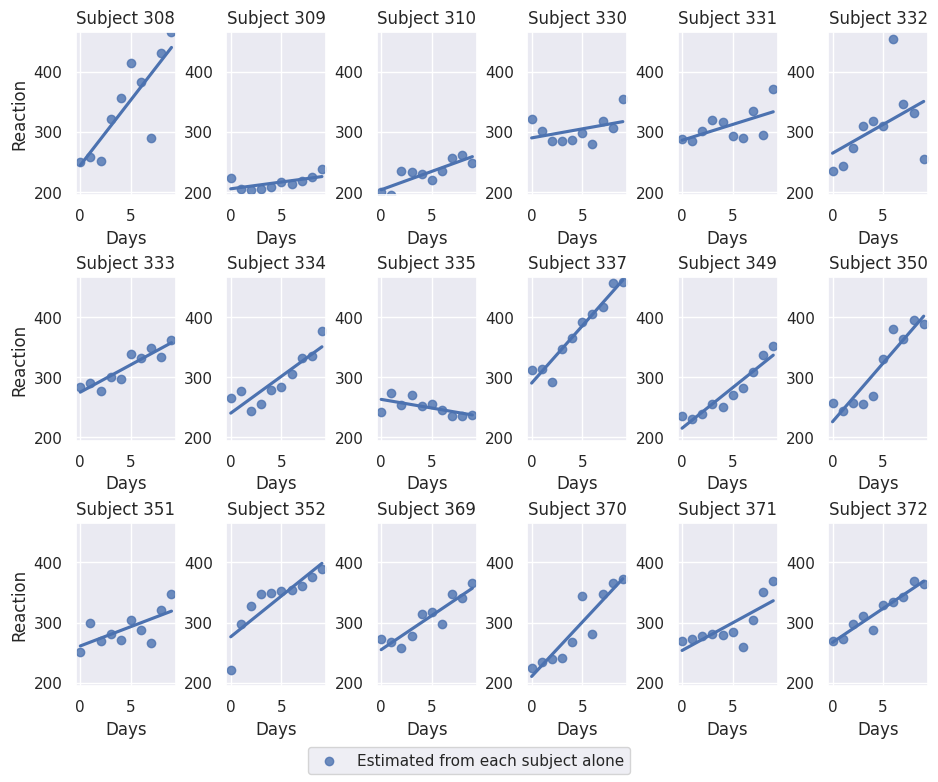

In [37]:
import statsmodels.formula.api as sm
import seaborn as sns
from matplotlib import gridspec


ymin,ymax = np.min(sleepstudy["Reaction"]),np.max(sleepstudy["Reaction"])
plt.figure(figsize=(11,8.5))
gs  = gridspec.GridSpec(3, 6)
gs.update(wspace=0.5, hspace=0.5)
for i, subj in enumerate(np.unique(sleepstudy['Subject'])):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    ss_extract_ols = sm.ols(formula="Reaction~Days",data=ss_extract).fit()
    #new subplot
    subplt = plt.subplot(gs[i])
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj))
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)

_ = plt.figlegend(['Estimated from each subject alone'],loc = 'lower center', ncol=6)
_ = plt.show()

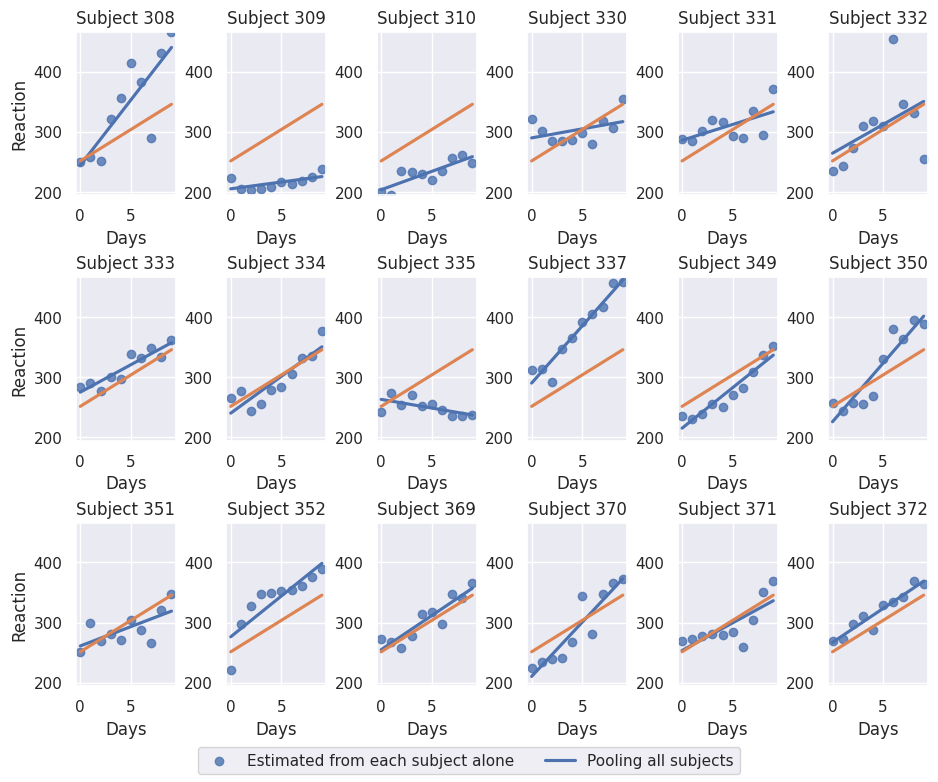

In [38]:
plt.figure(figsize=(11,8.5))
for i, subj in enumerate(np.unique(sleepstudy['Subject'])):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    #new subplot
    subplt = plt.subplot(gs[i])
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj))
    sns.regplot(x='Days', y='Reaction', ci=None, scatter=False, data=sleepstudy)
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)

_ = plt.figlegend(['Estimated from each subject alone','Pooling all subjects'],loc = 'lower center', ncol=6)
_ = plt.show()

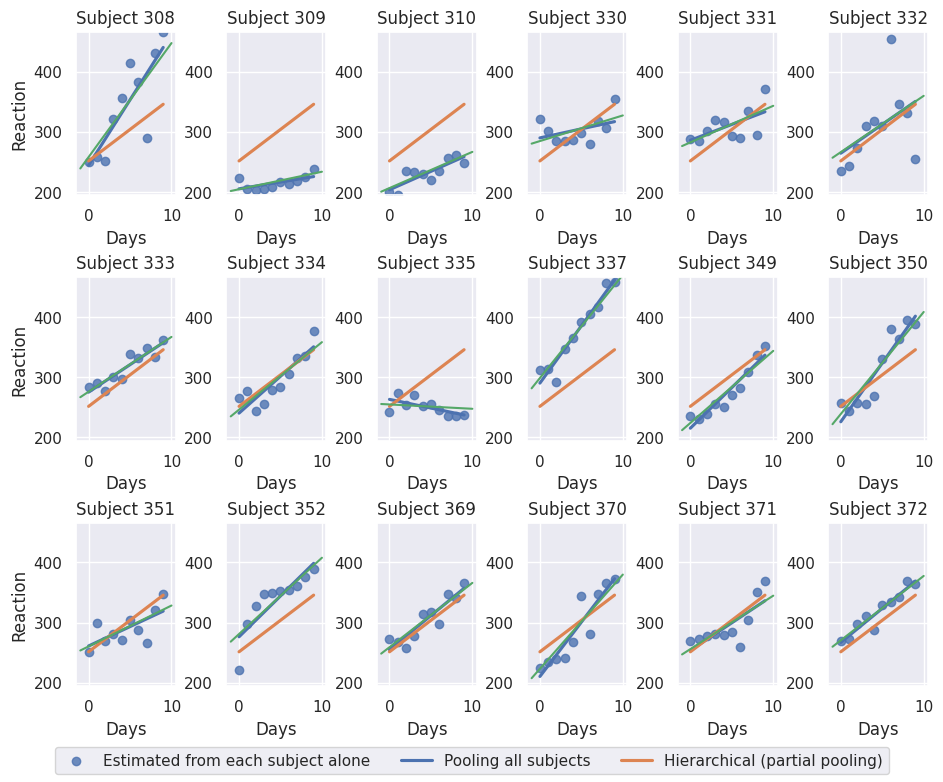

In [41]:
plt.figure(figsize=(11,8.5))
subj_arr = np.unique(sleepstudy['Subject'])
for i, subj in enumerate(subj_arr):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    #new subplot
    subplt = plt.subplot(gs[i])

    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj))
    sns.regplot(x='Days', y='Reaction', ci=None, scatter=False, data=sleepstudy)

    subj_num = np.where(subj_arr == subj)[0].item()

    subjects_avg_intercept = trace.posterior['alpha'].mean(dim=("chain", "draw")).values[i]
    subjects_avg_slope = trace.posterior['beta'].mean(dim=("chain", "draw")).values[i]

    hmodel_fit = [subjects_avg_intercept + subjects_avg_slope*x for x in range(-1,11)]
    sns.lineplot(x=range(-1,11),y=hmodel_fit)
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)

_ = plt.figlegend(['Estimated from each subject alone','Pooling all subjects','Hierarchical (partial pooling)'],loc = 'lower center', ncol=6)
_ = plt.show()

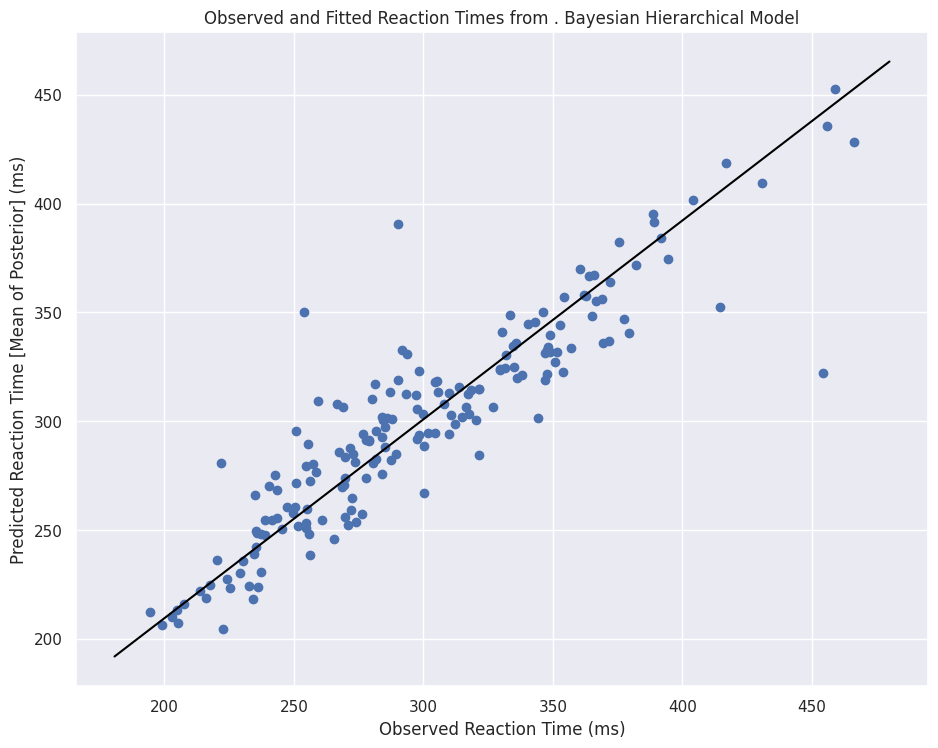

In [45]:
model_predictions = trace.posterior['mu_i'].mean(dim=("chain", "draw")).values.flatten()
obs_reactions = sleepstudy['Reaction'].values

plt.figure(figsize=(11,8.5))
plt.scatter(sleepstudy['Reaction'], model_predictions)
plt.plot(plt.xlim(), plt.ylim(), c='black')
plt.xlabel("Observed Reaction Time (ms)")
plt.ylabel("Predicted Reaction Time [Mean of Posterior] (ms)")
plt.title("Observed and Fitted Reaction Times from . Bayesian Hierarchical Model")
plt.show()